In [1]:
!pwd

/Users/jerrylin/Desktop/OfflineWork/hypersampling


# Import packages

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
import scipy
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.pylab as plb
from scipy.stats import ranksums
import os
import pickle
from scipy.stats import norm
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu
from scipy.stats import gaussian_kde
from scipy.signal import argrelextrema

from tqdm import tqdm

from preprocessing_functions import *

# Load data

In [3]:
color_dict = {
    'standard': 'blue',
    'specific': 'lime',
    'nomemory': 'red',
    'nowind': 'green',
    'noozone': 'purple',
    'nocoszrs': 'orange',
    'mae': 'pink',
    'nodropout': 'silver',
    'multiclimate': 'gold'
}

color_dict2 = {
    'standard': 'blue',
    'specific': 'lime',
    'no memory': 'red',
    'no wind': 'green',
    'no ozone': 'purple',
    'no zenith angle': 'orange',
    'MAE':'pink',
    'no dropout': 'silver',
    'multiclimate': 'gold'
}

label_dict = {
    'standard': 'standard',
    'specific': 'specific humidity',
    'nomemory': 'no memory',
    'nowind': 'no wind',
    'noozone': 'no ozone',
    'nocoszrs': 'no zenith angle',
    'mae': 'MAE',
    'nodropout': 'no dropout',
    'multiclimate': 'multiclimate'
}

config_names = ['standard', 'specific humidity', 'no memory', 'no wind', 'no ozone', 'no zenith angle', 'MAE', 'no dropout', 'multiclimate']

average_heating_rmse = 4.567616448322416e-05
average_moistening_rmse = 2.8896629675143484e-05
martingale_heating_rmse = 3.1405422356850924e-05
martingale_moistening_rmse = 2.9224563847088255e-05
mlr_heating_rmse = 2.600916471955618e-05
mlr_moistening_rmse = 2.229119069533864e-05

def get_model_info(config_name):
    model_info = pd.read_pickle(f'{config_name}/{config_name}_df.pandas.pkl')
    with open(f'{config_name}/prognostic_T.pkl', 'rb') as f:
        prognostic_T = pickle.load(f)
    with open(f'{config_name}/prognostic_Q.pkl', 'rb') as f:
        prognostic_Q = pickle.load(f)
    return model_info, prognostic_T, prognostic_Q

def get_drift_col(prognostic_diffs, model_info, name, threshold):
    return pd.Series([sum(prognostic_diffs[x]>threshold)!=0 for x in prognostic_diffs], name = name, index = model_info.index)

standard_model_info, standard_prognostic_T, standard_prognostic_Q = get_model_info('standard')
specific_model_info, specific_prognostic_T, specific_prognostic_Q = get_model_info('specific')
nomemory_model_info, nomemory_prognostic_T, nomemory_prognostic_Q = get_model_info('nomemory')
nowind_model_info, nowind_prognostic_T, nowind_prognostic_Q = get_model_info('nowind')
noozone_model_info, noozone_prognostic_T, noozone_prognostic_Q = get_model_info('noozone')
nocoszrs_model_info, nocoszrs_prognostic_T, nocoszrs_prognostic_Q = get_model_info('nocoszrs')
mae_model_info, mae_prognostic_T, mae_prognostic_Q = get_model_info('mae')
nodropout_model_info, nodropout_prognostic_T, nodropout_prognostic_Q = get_model_info('nodropout')
multiclimate_model_info, multiclimate_prognostic_T, multiclimate_prognostic_Q = get_model_info('multiclimate')

config_dict = {
    'standard': standard_model_info,
    'specific': specific_model_info,
    'nomemory': nomemory_model_info,
    'nowind': nowind_model_info,
    'noozone': noozone_model_info,
    'nocoszrs': nocoszrs_model_info,
    'mae': mae_model_info,
    'nodropout': nodropout_model_info,
    'multiclimate': multiclimate_model_info
}

survived_dict = {
    'standard': standard_model_info[standard_model_info['num_months']==12].copy(),
    'specific': specific_model_info[specific_model_info['num_months']==12].copy(),
    'nomemory': nomemory_model_info[nomemory_model_info['num_months']==12].copy(),
    'nowind': nowind_model_info[nowind_model_info['num_months']==12].copy(),
    'noozone': noozone_model_info[noozone_model_info['num_months']==12].copy(),
    'nocoszrs': nocoszrs_model_info[nocoszrs_model_info['num_months']==12].copy(),
    'mae': mae_model_info[mae_model_info['num_months']==12].copy(),
    'nodropout': nodropout_model_info[nodropout_model_info['num_months']==12].copy(),
    'multiclimate': multiclimate_model_info[multiclimate_model_info['num_months']==12].copy()
}

for config_name in survived_dict:
    survived_dict[config_name].loc[:, 'config_name'] = config_name

combined_df = pd.concat([survived_dict['standard'], \
                         survived_dict['specific'], \
                         survived_dict['nomemory'], \
                         survived_dict['nowind'], \
                         survived_dict['noozone'], \
                         survived_dict['nocoszrs'], \
                         survived_dict['mae'], \
                         survived_dict['nodropout'], \
                         survived_dict['multiclimate']])

online_temperature_overall = pd.concat([survived_dict['standard']['online_temperature'], \
                                        survived_dict['specific']['offline_moistening'], \
                                        survived_dict['nomemory']['online_temperature'], \
                                        survived_dict['nowind']['online_temperature'], \
                                        survived_dict['noozone']['online_temperature'], \
                                        survived_dict['nocoszrs']['online_temperature'], \
                                        survived_dict['mae']['online_temperature'], \
                                        survived_dict['nodropout']['online_temperature'], \
                                        survived_dict['multiclimate']['online_temperature']], axis = 0)
                            
online_moisture_overall = pd.concat([survived_dict['standard']['online_moisture'], \
                                     survived_dict['specific']['offline_moistening'], \
                                     survived_dict['nomemory']['online_moisture'], \
                                     survived_dict['nowind']['online_moisture'], \
                                     survived_dict['noozone']['online_moisture'], \
                                     survived_dict['nocoszrs']['online_moisture'], \
                                     survived_dict['mae']['online_moisture'], \
                                     survived_dict['nodropout']['online_moisture'], \
                                     survived_dict['multiclimate']['online_moisture']], axis = 0)

def get_top_models(config_name):
    top_models = set(sorted(list(survived_dict[config_name].sort_values('online_temperature').head().index) + list(survived_dict[config_name].sort_values('online_moisture').head().index)))
    print(len(top_models))
    return top_models


# Offline story

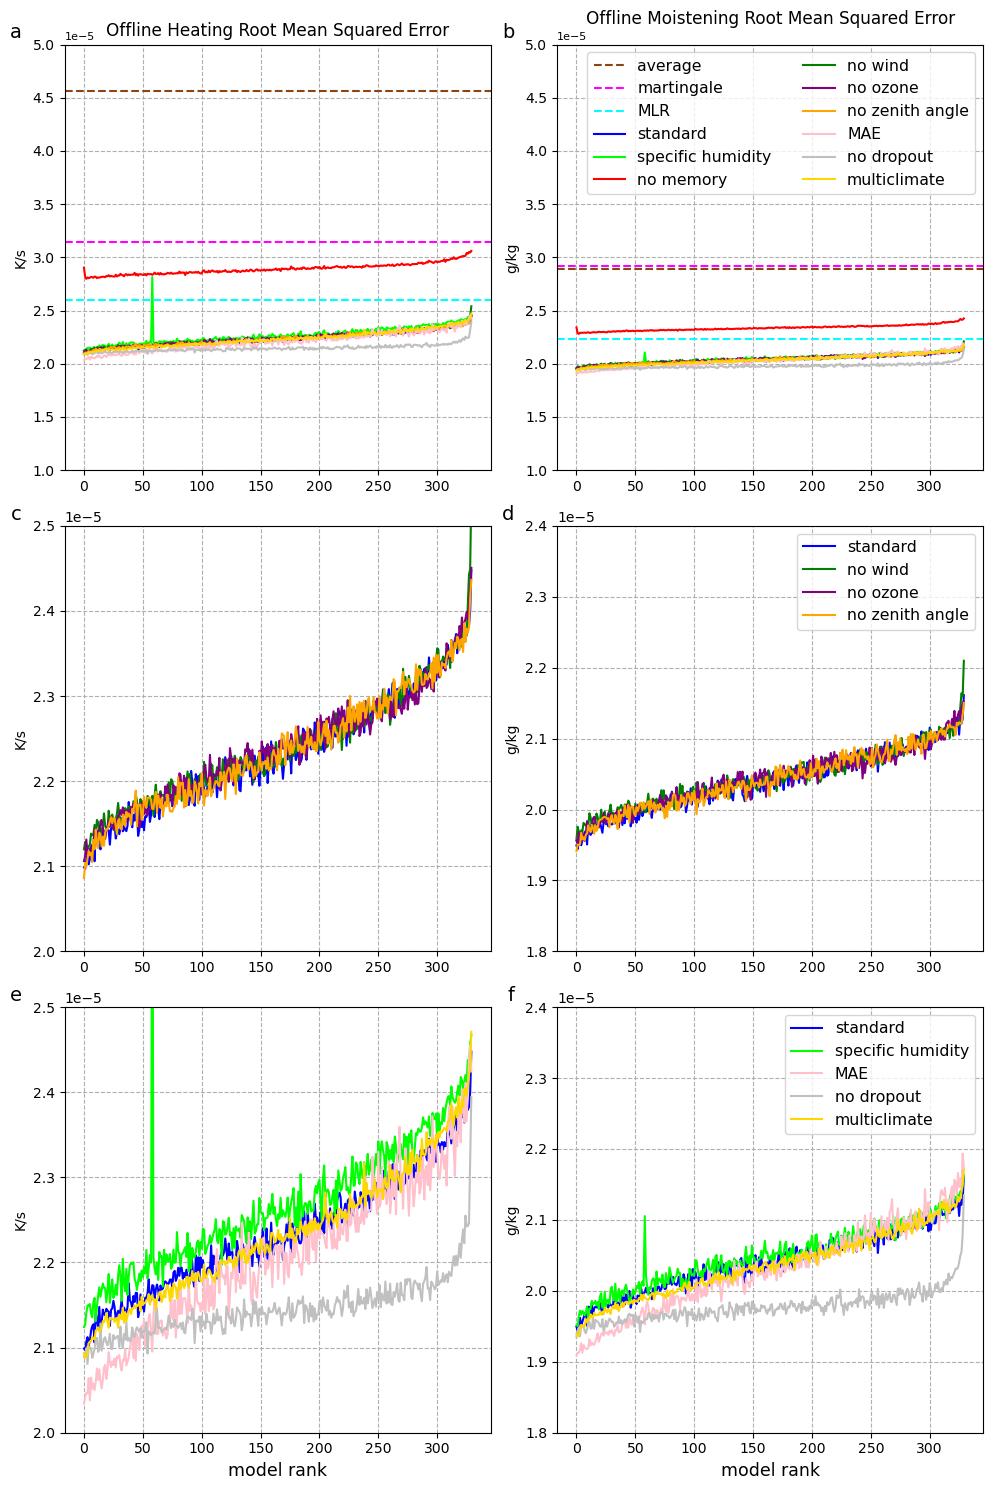

In [4]:
fig, axs = plt.subplots(3, 2, figsize=(10, 15))
title_fontsize = 12.1

heating_standard, = axs[0,0].plot(np.arange(330), standard_model_info['offline_heating'], color = color_dict['standard'], label='standard')
heating_specific = axs[0,0].plot(np.arange(330), specific_model_info['offline_heating'], color = color_dict['specific'], label='specific humidity')
heating_nomemory, = axs[0,0].plot(np.arange(330), nomemory_model_info['offline_heating'], color = color_dict['nomemory'], label='no memory')
heating_nowind, = axs[0,0].plot(np.arange(330), nowind_model_info['offline_heating'], color = color_dict['nowind'], label='no wind')
heating_noozone, = axs[0,0].plot(np.arange(330), noozone_model_info['offline_heating'], color = color_dict['noozone'], label='no ozone')
heating_nocoszrs, = axs[0,0].plot(np.arange(330), nocoszrs_model_info['offline_heating'], color = color_dict['nocoszrs'], label='no zenith angle')
heating_mae, = axs[0,0].plot(np.arange(330), mae_model_info['offline_heating'], color = color_dict['mae'], label='MAE')
heating_nodropout, = axs[0,0].plot(np.arange(330), nodropout_model_info['offline_heating'], color = color_dict['nodropout'], label='no dropout')
heating_multiclimate, = axs[0,0].plot(np.arange(330), multiclimate_model_info['offline_heating'], color = color_dict['multiclimate'], label='multiclimate')

heating_standard, = axs[1,0].plot(np.arange(330), standard_model_info['offline_heating'], color = color_dict['standard'], label='standard')
heating_nowind, = axs[1,0].plot(np.arange(330), nowind_model_info['offline_heating'], color = color_dict['nowind'], label='no wind')
heating_noozone, = axs[1,0].plot(np.arange(330), noozone_model_info['offline_heating'], color = color_dict['noozone'], label='no ozone')
heating_nocoszrs, = axs[1,0].plot(np.arange(330), nocoszrs_model_info['offline_heating'], color = color_dict['nocoszrs'], label='no zenith angle')

heating_standard, = axs[2,0].plot(np.arange(330), standard_model_info['offline_heating'], color = color_dict['standard'], label='standard')
heating_specific = axs[2,0].plot(np.arange(330), specific_model_info['offline_heating'], color = color_dict['specific'], label='specific humidity')
heating_mae, = axs[2,0].plot(np.arange(330), mae_model_info['offline_heating'], color = color_dict['mae'], label='MAE')
heating_nodropout, = axs[2,0].plot(np.arange(330), nodropout_model_info['offline_heating'], color = color_dict['nodropout'], label='no dropout')
heating_multiclimate, = axs[2,0].plot(np.arange(330), multiclimate_model_info['offline_heating'], color = color_dict['multiclimate'], label='multiclimate')

moistening_standard, = axs[0,1].plot(np.arange(330), standard_model_info['offline_moistening'], color = color_dict['standard'], label='standard')
moistening_specific, = axs[0,1].plot(np.arange(330), specific_model_info['offline_moistening'], color = color_dict['specific'], label='specific humidity')
moistening_nomemory, = axs[0,1].plot(np.arange(330), nomemory_model_info['offline_moistening'], color = color_dict['nomemory'], label='no memory')
moistening_nowind, = axs[0,1].plot(np.arange(330), nowind_model_info['offline_moistening'], color = color_dict['nowind'], label='no wind')
moistening_noozone, = axs[0,1].plot(np.arange(330), noozone_model_info['offline_moistening'], color = color_dict['noozone'], label='no ozone')
moistening_nocoszrs, = axs[0,1].plot(np.arange(330), nocoszrs_model_info['offline_moistening'], color = color_dict['nocoszrs'], label='no zenith angle')
moistening_mae, = axs[0,1].plot(np.arange(330), mae_model_info['offline_moistening'], color = color_dict['mae'], label='MAE')
moistening_nodropout, = axs[0,1].plot(np.arange(330), nodropout_model_info['offline_moistening'], color = color_dict['nodropout'], label='no dropout')
moistening_multiclimate, = axs[0,1].plot(np.arange(330), multiclimate_model_info['offline_moistening'], color = color_dict['multiclimate'], label='multiclimate')

moistening_standard, = axs[1,1].plot(np.arange(330), standard_model_info['offline_moistening'], color = color_dict['standard'], label='standard')
moistening_nowind, = axs[1,1].plot(np.arange(330), nowind_model_info['offline_moistening'], color = color_dict['nowind'], label='no wind')
moistening_noozone, = axs[1,1].plot(np.arange(330), noozone_model_info['offline_moistening'], color = color_dict['noozone'], label='no ozone')
moistening_nocoszrs, = axs[1,1].plot(np.arange(330), nocoszrs_model_info['offline_moistening'], color = color_dict['nocoszrs'], label='no zenith angle')

moistening_standard, = axs[2,1].plot(np.arange(330), standard_model_info['offline_moistening'], color = color_dict['standard'], label='standard')
moistening_specific, = axs[2,1].plot(np.arange(330), specific_model_info['offline_moistening'], color = color_dict['specific'], label='specific humidity')
moistening_mae, = axs[2,1].plot(np.arange(330), mae_model_info['offline_moistening'], color = color_dict['mae'], label='MAE')
moistening_nodropout, = axs[2,1].plot(np.arange(330), nodropout_model_info['offline_moistening'], color = color_dict['nodropout'], label='no dropout')
moistening_multiclimate, = axs[2,1].plot(np.arange(330), multiclimate_model_info['offline_moistening'], color = color_dict['multiclimate'], label='multiclimate')

axs[0,0].yaxis.get_offset_text().set_size(8) 
axs[0,0].set_title('Offline Heating Root Mean Squared Error', fontsize = title_fontsize)
axs[2,0].set_xlabel('model rank', fontsize = 12.5)
axs[0,0].set_ylabel('K/s')
axs[1,0].set_ylabel('K/s')
axs[2,0].set_ylabel('K/s')
axs[0,0].set_ylim(1e-5, 5e-5)
axs[1,0].set_ylim(2e-5, 2.5e-5)
axs[2,0].set_ylim(2e-5, 2.5e-5)
axs[0,0].grid(True, which="both", ls="--")
axs[1,0].grid(True, which="both", ls="--")
axs[2,0].grid(True, which="both", ls="--")
axs[0,0].axhline(y = average_heating_rmse, color='#8B4513', linestyle='--', label='average heating RMSE')
axs[0,0].axhline(y = martingale_heating_rmse, color='#FF00FF', linestyle='--', label='martingale heating RMSE')
axs[0,0].axhline(y = mlr_heating_rmse, color='#00FFFF', linestyle='--', label='MLR heating RMSE')

axs[0,1].yaxis.get_offset_text().set_size(8) 
axs[0,1].set_title('Offline Moistening Root Mean Squared Error', fontsize = title_fontsize)
axs[2,1].set_xlabel('model rank', fontsize = 12.5)
axs[0,1].set_ylabel('g/kg')
axs[1,1].set_ylabel('g/kg')
axs[2,1].set_ylabel('g/kg')
axs[0,1].set_ylim(1e-5, 5e-5)
axs[1,1].set_ylim(1.8e-5, 2.4e-5)
axs[2,1].set_ylim(1.8e-5, 2.4e-5)
axs[0,1].grid(True, which="both", ls="--")
axs[1,1].grid(True, which="both", ls="--")
axs[2,1].grid(True, which="both", ls="--")
line_average = axs[0,1].axhline(y = average_moistening_rmse, color='#8B4513', linestyle='--', label='average moistening RMSE')
line_martingale = axs[0,1].axhline(y = martingale_moistening_rmse, color='#FF00FF', linestyle='--', label='martingale moistening RMSE')
line_mlr = axs[0,1].axhline(y = mlr_moistening_rmse, color='#00FFFF', linestyle='--', label='MLR moistening RMSE')
axs[0,1].legend([line_average, \
               line_martingale, \
               line_mlr, \
               moistening_standard, \
               moistening_specific, \
               moistening_nomemory, \
               moistening_nowind, \
               moistening_noozone, \
               moistening_nocoszrs, \
               moistening_mae, \
               moistening_nodropout, \
               moistening_multiclimate], \
               ['average', 'martingale', 'MLR'] + config_names, loc='upper right', ncol = 2, fontsize = 11.3)
axs[1,1].legend([moistening_standard, \
               moistening_nowind, \
               moistening_noozone, \
               moistening_nocoszrs], \
               ['standard', 'no wind', 'no ozone', 'no zenith angle'], loc='upper right', fontsize = 11.3)
axs[2,1].legend([moistening_standard, \
               moistening_specific, \
               moistening_mae, \
               moistening_nodropout, \
               moistening_multiclimate], \
               ['standard', 'specific humidity', 'MAE', 'no dropout', 'multiclimate'], loc='upper right', fontsize = 11.3)
sublabels = ['a', 'b', 'c', 'd', 'e', 'f']
for i, ax in enumerate(axs.flat):
    ax.text(-0.1, 1.05, sublabels[i], transform=ax.transAxes,
            fontsize=14, va='top', ha='right')

plt.tight_layout()
plt.show()

# Online story

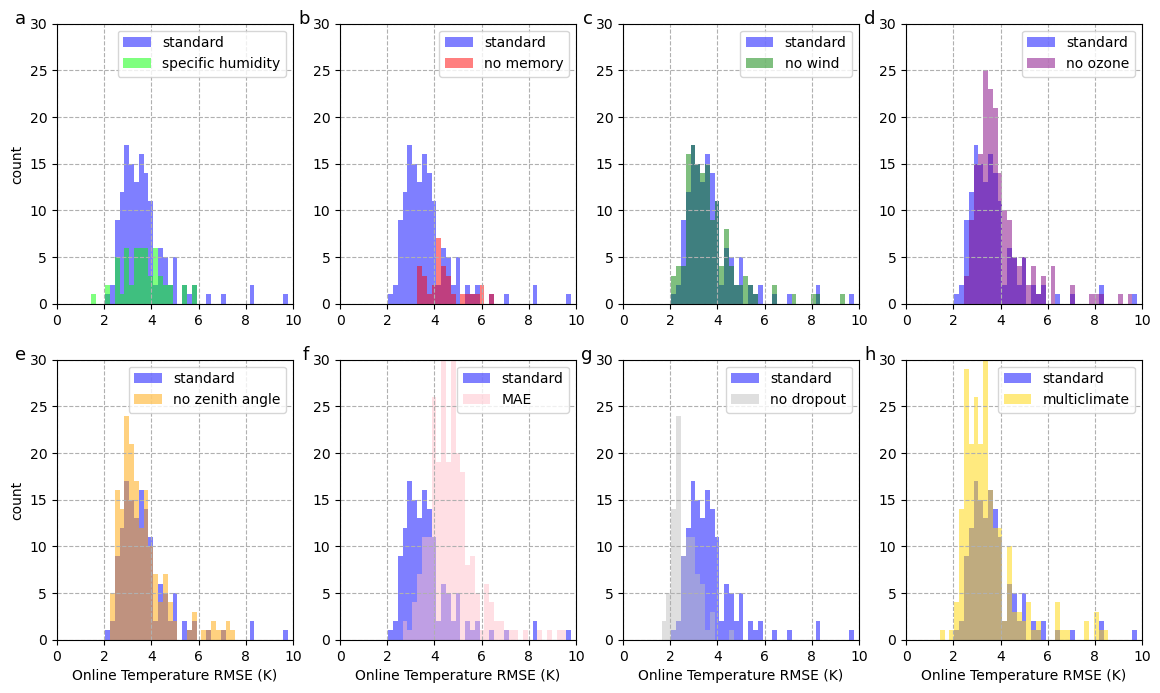

In [5]:
fig, axs = plt.subplots(2, 4, figsize=(14, 8))
alpha = .5
# Define the number of bins and bin edges
bins = np.linspace(0, 10, 50)

# Plot histograms
axs[0,0].hist(survived_dict['standard']['online_temperature'], bins = bins, label=label_dict['standard'], color = color_dict['standard'], alpha = alpha)
axs[0,0].hist(survived_dict['specific']['online_temperature'], bins = bins, label=label_dict['specific'], color = color_dict['specific'], alpha = alpha)
axs[0,0].set_ylim(0, 30)
axs[0,0].set_xlim(0, 10)
axs[0,0].set_ylabel('count')

axs[0,0].legend()

axs[0,1].hist(survived_dict['standard']['online_temperature'], bins = bins, label=label_dict['standard'], color = color_dict['standard'], alpha = alpha)
axs[0,1].hist(survived_dict['nomemory']['online_temperature'], bins = bins, label=label_dict['nomemory'], color = color_dict['nomemory'], alpha = alpha)
axs[0,1].set_ylim(0, 30)
axs[0,1].set_xlim(0, 10)
axs[0,1].legend()

axs[0,2].hist(survived_dict['standard']['online_temperature'], bins = bins, label=label_dict['standard'], color = color_dict['standard'], alpha = alpha)
axs[0,2].hist(survived_dict['nowind']['online_temperature'], bins = bins, label=label_dict['nowind'], color = color_dict['nowind'], alpha = alpha)
axs[0,2].set_ylim(0, 30)
axs[0,2].set_xlim(0, 10)
axs[0,2].legend()

axs[0,3].hist(survived_dict['standard']['online_temperature'], bins = bins, label=label_dict['standard'], color = color_dict['standard'], alpha = alpha)
axs[0,3].hist(survived_dict['noozone']['online_temperature'], bins = bins, label=label_dict['noozone'], color = color_dict['noozone'], alpha = alpha)
axs[0,3].set_ylim(0, 30)
axs[0,3].set_xlim(0, 10)
axs[0,3].legend()

axs[1,0].hist(survived_dict['standard']['online_temperature'], bins = bins, label=label_dict['standard'], color = color_dict['standard'], alpha = alpha)
axs[1,0].hist(survived_dict['nocoszrs']['online_temperature'], bins = bins, label=label_dict['nocoszrs'], color = color_dict['nocoszrs'], alpha = alpha)
axs[1,0].set_ylim(0, 30)
axs[1,0].set_xlim(0, 10)
axs[1,0].legend()
axs[1,0].set_xlabel('Online Temperature RMSE (K)')
axs[1,0].set_ylabel('count')

axs[1,1].hist(survived_dict['standard']['online_temperature'], bins = bins, label=label_dict['standard'], color = color_dict['standard'], alpha = alpha)
axs[1,1].hist(survived_dict['mae']['online_temperature'], bins = bins, label=label_dict['mae'], color = color_dict['mae'], alpha = alpha)
axs[1,1].set_ylim(0, 30)
axs[1,1].set_xlim(0, 10)
axs[1,1].legend()
axs[1,1].set_xlabel('Online Temperature RMSE (K)')

axs[1,2].hist(survived_dict['standard']['online_temperature'], bins = bins, label=label_dict['standard'], color = color_dict['standard'], alpha = alpha)
axs[1,2].hist(survived_dict['nodropout']['online_temperature'], bins = bins, label=label_dict['nodropout'], color = color_dict['nodropout'], alpha = alpha)
axs[1,2].set_ylim(0, 30)
axs[1,2].set_xlim(0, 10)
axs[1,2].legend()
axs[1,2].set_xlabel('Online Temperature RMSE (K)')

axs[1,3].hist(survived_dict['standard']['online_temperature'], bins = bins, label=label_dict['standard'], color = color_dict['standard'], alpha = alpha)
axs[1,3].hist(survived_dict['multiclimate']['online_temperature'], bins = bins, label=label_dict['multiclimate'], color = color_dict['multiclimate'], alpha = alpha)
axs[1,3].set_ylim(0, 30)
axs[1,3].set_xlim(0, 10)
axs[1,3].legend()
axs[1,3].set_xlabel('Online Temperature RMSE (K)')

axs[0,0].grid(True, which="both", ls="--")
axs[0,1].grid(True, which="both", ls="--")
axs[0,2].grid(True, which="both", ls="--")
axs[0,3].grid(True, which="both", ls="--")
axs[1,0].grid(True, which="both", ls="--")
axs[1,1].grid(True, which="both", ls="--")
axs[1,2].grid(True, which="both", ls="--")
axs[1,3].grid(True, which="both", ls="--")

sublabels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
for i, ax in enumerate(axs.flat):
    ax.text(-0.13, 1.05, sublabels[i], transform=ax.transAxes,
            fontsize=13, va='top', ha='right')

# Add legend and labels
# plt.legend(loc='upper right')
# plt.xlabel('K')
# plt.xlim(0,10)
# plt.ylabel('Frequency')
# plt.title('Online Temperature Error')

# Show the plot
plt.show()

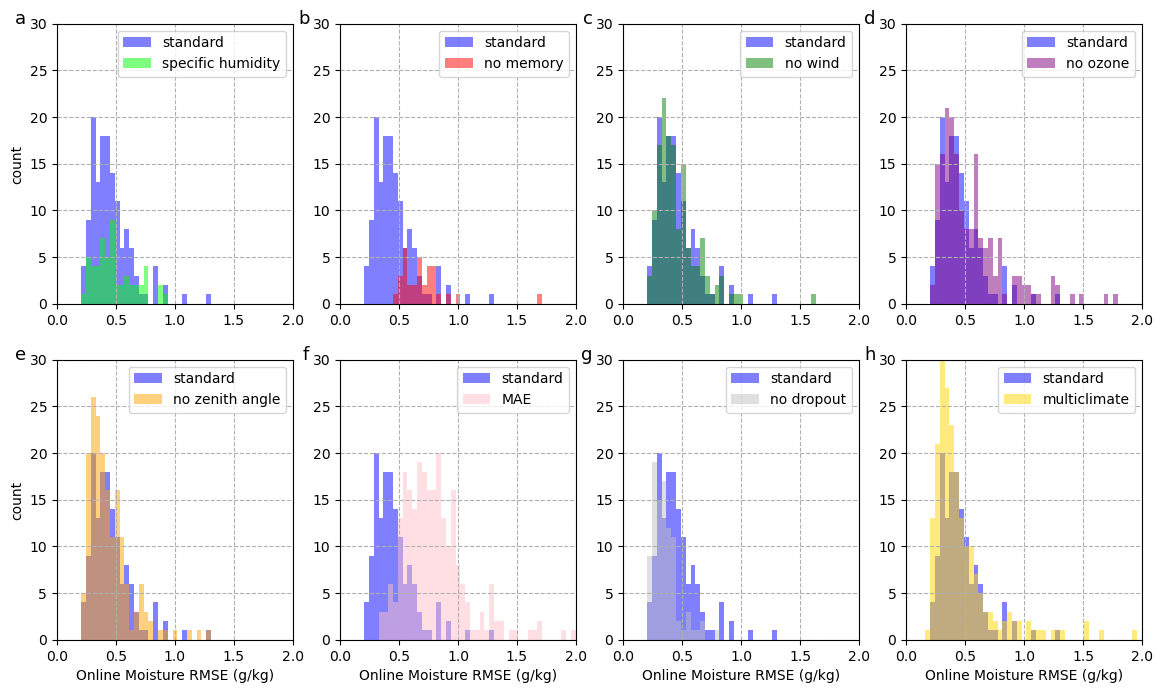

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(14, 8))
alpha = .5
# Define the number of bins and bin edges
bins = np.linspace(0, 2, 50)

# Plot histograms
axs[0,0].hist(survived_dict['standard']['online_moisture'], bins = bins, label=label_dict['standard'], color = color_dict['standard'], alpha = alpha)
axs[0,0].hist(survived_dict['specific']['online_moisture'], bins = bins, label=label_dict['specific'], color = color_dict['specific'], alpha = alpha)
axs[0,0].set_ylim(0, 30)
axs[0,0].set_xlim(0, 2)
axs[0,0].set_ylabel('count')

axs[0,0].legend()

axs[0,1].hist(survived_dict['standard']['online_moisture'], bins = bins, label=label_dict['standard'], color = color_dict['standard'], alpha = alpha)
axs[0,1].hist(survived_dict['nomemory']['online_moisture'], bins = bins, label=label_dict['nomemory'], color = color_dict['nomemory'], alpha = alpha)
axs[0,1].set_ylim(0, 30)
axs[0,1].set_xlim(0, 2)
axs[0,1].legend()

axs[0,2].hist(survived_dict['standard']['online_moisture'], bins = bins, label=label_dict['standard'], color = color_dict['standard'], alpha = alpha)
axs[0,2].hist(survived_dict['nowind']['online_moisture'], bins = bins, label=label_dict['nowind'], color = color_dict['nowind'], alpha = alpha)
axs[0,2].set_ylim(0, 30)
axs[0,2].set_xlim(0, 2)
axs[0,2].legend()

axs[0,3].hist(survived_dict['standard']['online_moisture'], bins = bins, label=label_dict['standard'], color = color_dict['standard'], alpha = alpha)
axs[0,3].hist(survived_dict['noozone']['online_moisture'], bins = bins, label=label_dict['noozone'], color = color_dict['noozone'], alpha = alpha)
axs[0,3].set_ylim(0, 30)
axs[0,3].set_xlim(0, 2)
axs[0,3].legend()

axs[1,0].hist(survived_dict['standard']['online_moisture'], bins = bins, label=label_dict['standard'], color = color_dict['standard'], alpha = alpha)
axs[1,0].hist(survived_dict['nocoszrs']['online_moisture'], bins = bins, label=label_dict['nocoszrs'], color = color_dict['nocoszrs'], alpha = alpha)
axs[1,0].set_ylim(0, 30)
axs[1,0].set_xlim(0, 2)
axs[1,0].legend()
axs[1,0].set_xlabel('Online Moisture RMSE (g/kg)')
axs[1,0].set_ylabel('count')

axs[1,1].hist(survived_dict['standard']['online_moisture'], bins = bins, label=label_dict['standard'], color = color_dict['standard'], alpha = alpha)
axs[1,1].hist(survived_dict['mae']['online_moisture'], bins = bins, label=label_dict['mae'], color = color_dict['mae'], alpha = alpha)
axs[1,1].set_ylim(0, 30)
axs[1,1].set_xlim(0, 2)
axs[1,1].legend()
axs[1,1].set_xlabel('Online Moisture RMSE (g/kg)')

axs[1,2].hist(survived_dict['standard']['online_moisture'], bins = bins, label=label_dict['standard'], color = color_dict['standard'], alpha = alpha)
axs[1,2].hist(survived_dict['nodropout']['online_moisture'], bins = bins, label=label_dict['nodropout'], color = color_dict['nodropout'], alpha = alpha)
axs[1,2].set_ylim(0, 30)
axs[1,2].set_xlim(0, 2)
axs[1,2].legend()
axs[1,2].set_xlabel('Online Moisture RMSE (g/kg)')

axs[1,3].hist(survived_dict['standard']['online_moisture'], bins = bins, label=label_dict['standard'], color = color_dict['standard'], alpha = alpha)
axs[1,3].hist(survived_dict['multiclimate']['online_moisture'], bins = bins, label=label_dict['multiclimate'], color = color_dict['multiclimate'], alpha = alpha)
axs[1,3].set_ylim(0, 30)
axs[1,3].set_xlim(0, 2)
axs[1,3].legend()
axs[1,3].set_xlabel('Online Moisture RMSE (g/kg)')

axs[0,0].grid(True, which="both", ls="--")
axs[0,1].grid(True, which="both", ls="--")
axs[0,2].grid(True, which="both", ls="--")
axs[0,3].grid(True, which="both", ls="--")
axs[1,0].grid(True, which="both", ls="--")
axs[1,1].grid(True, which="both", ls="--")
axs[1,2].grid(True, which="both", ls="--")
axs[1,3].grid(True, which="both", ls="--")

sublabels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
for i, ax in enumerate(axs.flat):
    ax.text(-0.13, 1.05, sublabels[i], transform=ax.transAxes,
            fontsize=13, va='top', ha='right')

# Add legend and labels
# plt.legend(loc='upper right')
# plt.xlabel('K')
# plt.xlim(0,10)
# plt.ylabel('Frequency')
# plt.title('Online Temperature Error')

# Show the plot
plt.show()

# Offline vs. Online story

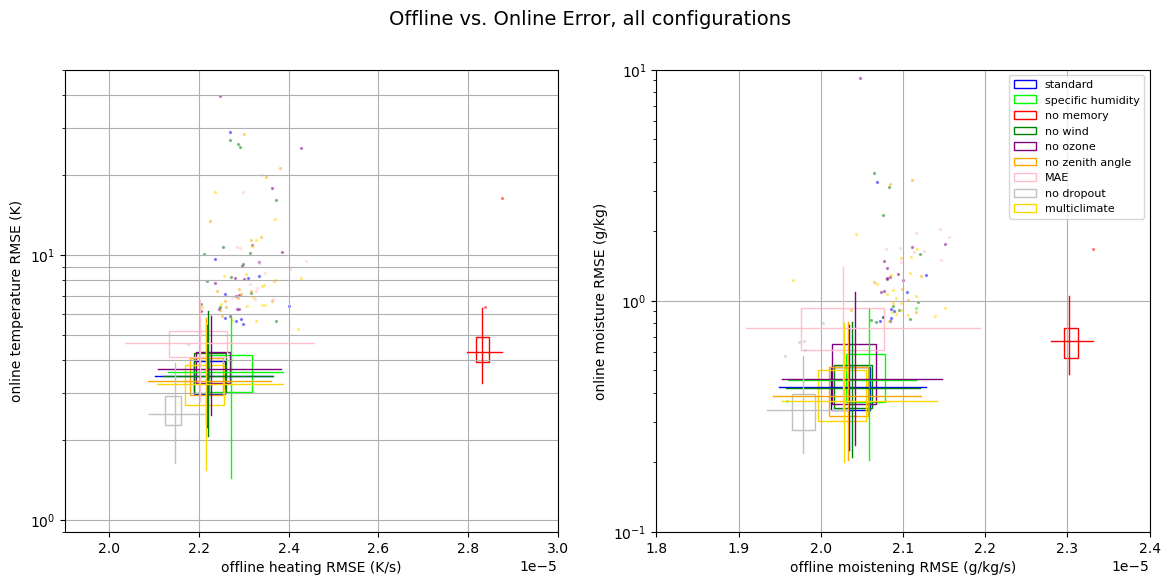

In [7]:
def make_boxplots(model_dicts):
    # Create a new figure and axis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Define the position and size of the square
    handles_Q = []
    for config in model_dicts:
        model_info = model_dicts[config]
        label = label_dict[config]
        color = color_dict[config]

        offline_min_T = model_info[model_info['num_months']==12]['offline_heating'].min()
        offline_25_T = model_info[model_info['num_months']==12]['offline_heating'].quantile(.25)
        offline_50_T = model_info[model_info['num_months']==12]['offline_heating'].quantile(.5)
        offline_75_T = model_info[model_info['num_months']==12]['offline_heating'].quantile(.75)
        offline_max_T = model_info[model_info['num_months']==12]['offline_heating'].max()
        offline_iqr_T = offline_75_T - offline_25_T
        offline_outlier_mask_low_T = model_info[model_info['num_months']==12]['offline_heating'] < offline_25_T - 1.5*offline_iqr_T
        offline_outlier_mask_high_T = model_info[model_info['num_months']==12]['offline_heating'] > offline_75_T + 1.5*offline_iqr_T
        online_min_T = model_info[model_info['num_months']==12]['online_temperature'].min()
        online_25_T = model_info[model_info['num_months']==12]['online_temperature'].quantile(.25)
        online_50_T = model_info[model_info['num_months']==12]['online_temperature'].quantile(.5)
        online_75_T = model_info[model_info['num_months']==12]['online_temperature'].quantile(.75)
        online_max_T = model_info[model_info['num_months']==12]['online_temperature'].max()
        online_iqr_T = online_75_T - online_25_T
        online_outlier_mask_low_T = model_info[model_info['num_months']==12]['online_temperature'] < online_25_T - 1.5*online_iqr_T
        online_outlier_mask_high_T = model_info[model_info['num_months']==12]['online_temperature'] > online_75_T + 1.5*online_iqr_T
        outlier_mask_T = offline_outlier_mask_low_T | offline_outlier_mask_high_T | online_outlier_mask_low_T | online_outlier_mask_high_T
        outliers_T = model_info[model_info['num_months']==12][outlier_mask_T]
        x_T, y_T = offline_25_T, online_25_T  # bottom left corner
        width_T, height_T = offline_75_T - offline_25_T, online_75_T - online_25_T  # width and height of the square
        square_T = patches.Rectangle((x_T, y_T), width_T, height_T, linewidth=1, edgecolor = color, facecolor = 'none')
        ax1.plot([offline_50_T, offline_50_T], [max(online_min_T, online_25_T - 1.5*online_iqr_T), min(online_max_T, online_75_T + 1.5*online_iqr_T)], color = color, linewidth=1)
        ax1.plot([max(offline_min_T, offline_25_T - 1.5*offline_iqr_T), min(offline_max_T, offline_75_T + 1.5*offline_iqr_T)], [online_50_T, online_50_T], color=color, linewidth=1)
        ax1.scatter(outliers_T['offline_heating'], outliers_T['online_temperature'], color = color, s = 2, alpha = .4)
        ax1.add_patch(square_T)

        offline_min_Q = model_info[model_info['num_months']==12]['offline_moistening'].min()
        offline_25_Q = model_info[model_info['num_months']==12]['offline_moistening'].quantile(.25)
        offline_50_Q = model_info[model_info['num_months']==12]['offline_moistening'].quantile(.5)
        offline_75_Q = model_info[model_info['num_months']==12]['offline_moistening'].quantile(.75)
        offline_max_Q = model_info[model_info['num_months']==12]['offline_moistening'].max()
        offline_iqr_Q = offline_75_Q - offline_25_Q
        offline_outlier_mask_low_Q = model_info[model_info['num_months']==12]['offline_moistening'] < offline_25_Q - 1.5*offline_iqr_Q
        offline_outlier_mask_high_Q = model_info[model_info['num_months']==12]['offline_moistening'] > offline_75_Q + 1.5*offline_iqr_Q
        online_min_Q = model_info[model_info['num_months']==12]['online_moisture'].min()
        online_25_Q = model_info[model_info['num_months']==12]['online_moisture'].quantile(.25)
        online_50_Q = model_info[model_info['num_months']==12]['online_moisture'].quantile(.5)
        online_75_Q = model_info[model_info['num_months']==12]['online_moisture'].quantile(.75)
        online_max_Q = model_info[model_info['num_months']==12]['online_moisture'].max()
        online_iqr_Q = online_75_Q - online_25_Q
        online_outlier_mask_low_Q = model_info[model_info['num_months']==12]['online_moisture'] < online_25_Q - 1.5*online_iqr_Q
        online_outlier_mask_high_Q = model_info[model_info['num_months']==12]['online_moisture'] > online_75_Q + 1.5*online_iqr_Q
        outlier_mask_Q = offline_outlier_mask_low_Q | offline_outlier_mask_high_Q | online_outlier_mask_low_Q | online_outlier_mask_high_Q
        outliers_Q = model_info[model_info['num_months']==12][outlier_mask_Q]
        x_Q, y_Q = offline_25_Q, online_25_Q  # bottom left corner
        width_Q, height_Q = offline_75_Q - offline_25_Q, online_75_Q - online_25_Q  # width and height of the square
        square_Q = patches.Rectangle((x_Q, y_Q), width_Q, height_Q, linewidth=1, edgecolor = color, facecolor = 'none', label = label)
        handles_Q.append(square_Q)
        ax2.plot([offline_50_Q, offline_50_Q], [max(online_min_Q, online_25_Q - 1.5*online_iqr_Q), min(online_max_Q, online_75_Q + 1.5*online_iqr_Q)], color = color, linewidth=1)
        ax2.plot([max(offline_min_Q, offline_25_Q - 1.5*offline_iqr_Q), min(offline_max_Q, offline_75_Q + 1.5*offline_iqr_Q)], [online_50_Q, online_50_Q], color=color, linewidth=1)
        ax2.scatter(outliers_Q['offline_moistening'], outliers_Q['online_moisture'], color = color, s = 2, alpha = .4)
        ax2.add_patch(square_Q)

    # Set the limits of the plot
    ax1.set_xlim(1.9e-5, 3e-5)
    ax1.set_ylim(.9, 50)
    ax1.set_xlabel('offline heating RMSE (K/s)')
    ax1.set_ylabel('online temperature RMSE (K)')
    ax2.set_xlim(1.8e-5, 2.4e-5)
    ax2.set_ylim(1e-1, 10)
    ax2.set_xlabel('offline moistening RMSE (g/kg/s)')
    ax2.set_ylabel('online moisture RMSE (g/kg)')

    # Add grid
    ax1.grid(True, which = 'both')
    ax1.set_yscale('log')
    ax2.grid(True)
    ax2.set_yscale('log')
    ax2.legend(handles = handles_Q, fontsize = 8)

    # Show the plot
    fig.suptitle('Offline vs. Online Error, all configurations', fontsize = 14)
    plt.show()

make_boxplots(config_dict)

# Hypothesis tests

In [8]:
def get_stability_pvalue(p1, p2, n1 = 330, n2 = 330):
    p = (p1 * n1 + p2 * n2) / (n1 + n2)
    zstatistic = (p1 - p2) / np.sqrt(p * (1 - p) * (1 / n1 + 1 / n2))
    if zstatistic < 0:
        return (stats.norm.cdf(zstatistic))*2
    else:
        return (1 - stats.norm.cdf(zstatistic))*2

stability_pvals = [get_stability_pvalue(len(survived_dict['specific'])/330, len(survived_dict['standard'])/330), \
                   get_stability_pvalue(len(survived_dict['nomemory'])/330, len(survived_dict['standard'])/330), \
                   get_stability_pvalue(len(survived_dict['nowind'])/330, len(survived_dict['standard'])/330), \
                   get_stability_pvalue(len(survived_dict['noozone'])/330, len(survived_dict['standard'])/330), \
                   get_stability_pvalue(len(survived_dict['nocoszrs'])/330, len(survived_dict['standard'])/330), \
                   get_stability_pvalue(len(survived_dict['mae'])/330, len(survived_dict['standard'])/330), \
                   get_stability_pvalue(len(survived_dict['nodropout'])/330, len(survived_dict['standard'])/330), \
                   get_stability_pvalue(len(survived_dict['multiclimate'])/330, len(survived_dict['standard'])/330)]

def permutation_test(df1, df2, var, quantile = .50, num_permutations = 10000):
    n1 = len(df1)
    observed_diff = df1[var].quantile(quantile) - df2[var].quantile(quantile)
    df = pd.concat([df1, df2], axis = 0)
    differences = []
    for i in range(num_permutations):
        df = df.sample(frac = 1).reset_index(drop=True)
        diff = df.iloc[:n1][var].quantile(quantile) - df.iloc[n1:][var].quantile(quantile)
        differences.append(diff)
    diffs = pd.Series(differences).sort_values()
    if observed_diff >= 0:
        p_value = 2*sum(diffs >= observed_diff)/num_permutations
    else:
        p_value = 2*sum(diffs < observed_diff)/num_permutations
    if p_value >= 1:
        p_value = 1
    return p_value

temperature_pvals = [permutation_test(survived_dict['specific'], survived_dict['standard'], var = 'online_temperature'),
                     permutation_test(survived_dict['nomemory'], survived_dict['standard'], var = 'online_temperature'),
                     permutation_test(survived_dict['nowind'], survived_dict['standard'], var = 'online_temperature'),
                     permutation_test(survived_dict['noozone'], survived_dict['standard'], var = 'online_temperature'),
                     permutation_test(survived_dict['nocoszrs'], survived_dict['standard'], var = 'online_temperature'),
                     permutation_test(survived_dict['mae'], survived_dict['standard'], var = 'online_temperature'),
                     permutation_test(survived_dict['nodropout'], survived_dict['standard'], var = 'online_temperature'),
                     permutation_test(survived_dict['multiclimate'], survived_dict['standard'], var = 'online_temperature')]

moisture_pvals = [permutation_test(survived_dict['specific'], survived_dict['standard'], var = 'online_moisture'),
                  permutation_test(survived_dict['nomemory'], survived_dict['standard'], var = 'online_moisture'),
                  permutation_test(survived_dict['nowind'], survived_dict['standard'], var = 'online_moisture'),
                  permutation_test(survived_dict['noozone'], survived_dict['standard'], var = 'online_moisture'),
                  permutation_test(survived_dict['nocoszrs'], survived_dict['standard'], var = 'online_moisture'),
                  permutation_test(survived_dict['mae'], survived_dict['standard'], var = 'online_moisture'),
                  permutation_test(survived_dict['nodropout'], survived_dict['standard'], var = 'online_moisture'),
                  permutation_test(survived_dict['multiclimate'], survived_dict['standard'], var = 'online_moisture')]

offline_heating_overall = pd.concat([survived_dict['standard']['offline_heating'], \
                                     survived_dict['specific']['offline_heating'], \
                                     survived_dict['nomemory']['offline_heating'], \
                                     survived_dict['nowind']['offline_heating'], \
                                     survived_dict['noozone']['offline_heating'], \
                                     survived_dict['nocoszrs']['offline_heating'], \
                                     survived_dict['mae']['offline_heating'], \
                                     survived_dict['nodropout']['offline_heating'], \
                                     survived_dict['multiclimate']['offline_heating']], axis = 0)

offline_moistening_overall = pd.concat([survived_dict['standard']['offline_moistening'], \
                                        survived_dict['specific']['offline_moistening'], \
                                        survived_dict['nomemory']['offline_moistening'], \
                                        survived_dict['nowind']['offline_moistening'], \
                                        survived_dict['noozone']['offline_moistening'], \
                                        survived_dict['nocoszrs']['offline_moistening'], \
                                        survived_dict['mae']['offline_moistening'], \
                                        survived_dict['nodropout']['offline_moistening'], \
                                        survived_dict['multiclimate']['offline_moistening']], axis = 0)

online_temperature_overall = pd.concat([survived_dict['standard']['online_temperature'], \
                                        survived_dict['specific']['offline_moistening'], \
                                        survived_dict['nomemory']['online_temperature'], \
                                        survived_dict['nowind']['online_temperature'], \
                                        survived_dict['noozone']['online_temperature'], \
                                        survived_dict['nocoszrs']['online_temperature'], \
                                        survived_dict['mae']['online_temperature'], \
                                        survived_dict['nodropout']['online_temperature'], \
                                        survived_dict['multiclimate']['online_temperature']], axis = 0)
                            
online_moisture_overall = pd.concat([survived_dict['standard']['online_moisture'], \
                                     survived_dict['specific']['offline_moistening'], \
                                     survived_dict['nomemory']['online_moisture'], \
                                     survived_dict['nowind']['online_moisture'], \
                                     survived_dict['noozone']['online_moisture'], \
                                     survived_dict['nocoszrs']['online_moisture'], \
                                     survived_dict['mae']['online_moisture'], \
                                     survived_dict['nodropout']['online_moisture'], \
                                     survived_dict['multiclimate']['online_moisture']], axis = 0)

overall_T_corr, overall_T_pval = spearmanr(offline_heating_overall, online_temperature_overall)
overall_Q_corr, overall_Q_pval = spearmanr(offline_moistening_overall, online_moisture_overall)

standard_T_corr, standard_T_pval = spearmanr(survived_dict['standard']['offline_heating'], survived_dict['standard']['online_temperature'])
specific_T_corr, specific_T_pval = spearmanr(survived_dict['specific']['offline_heating'], survived_dict['specific']['online_temperature'])
nomemory_T_corr, nomemory_T_pval = spearmanr(survived_dict['nomemory']['offline_heating'], survived_dict['nomemory']['online_temperature'])
nowind_T_corr, nowind_T_pval = spearmanr(survived_dict['nowind']['offline_heating'], survived_dict['nowind']['online_temperature'])
noozone_T_corr, noozone_T_pval = spearmanr(survived_dict['noozone']['offline_heating'], survived_dict['noozone']['online_temperature'])
nocoszrs_T_corr, nocoszrs_T_pval = spearmanr(survived_dict['nocoszrs']['offline_heating'], survived_dict['nocoszrs']['online_temperature'])
mae_T_corr, mae_T_pval = spearmanr(survived_dict['mae']['offline_heating'], survived_dict['mae']['online_temperature'])
nodropout_T_corr, nodropout_T_pval = spearmanr(survived_dict['nodropout']['offline_heating'], survived_dict['nodropout']['online_temperature'])
multiclimate_T_corr, multiclimate_T_pval = spearmanr(survived_dict['multiclimate']['offline_heating'], survived_dict['multiclimate']['online_temperature'])

standard_Q_corr, standard_Q_pval = spearmanr(survived_dict['standard']['offline_moistening'], survived_dict['standard']['online_moisture'])
specific_Q_corr, specific_Q_pval = spearmanr(survived_dict['specific']['offline_moistening'], survived_dict['specific']['online_moisture'])
nomemory_Q_corr, nomemory_Q_pval = spearmanr(survived_dict['nomemory']['offline_moistening'], survived_dict['nomemory']['online_moisture'])
nowind_Q_corr, nowind_Q_pval = spearmanr(survived_dict['nowind']['offline_moistening'], survived_dict['nowind']['online_moisture'])
noozone_Q_corr, noozone_Q_pval = spearmanr(survived_dict['noozone']['offline_moistening'], survived_dict['noozone']['online_moisture'])
nocoszrs_Q_corr, nocoszrs_Q_pval = spearmanr(survived_dict['nocoszrs']['offline_moistening'], survived_dict['nocoszrs']['online_moisture'])
mae_Q_corr, mae_Q_pval = spearmanr(survived_dict['mae']['offline_moistening'], survived_dict['mae']['online_moisture'])
nodropout_Q_corr, nodropout_Q_pval = spearmanr(survived_dict['nodropout']['offline_moistening'], survived_dict['nodropout']['online_moisture'])
multiclimate_Q_corr, multiclimate_Q_pval = spearmanr(survived_dict['multiclimate']['offline_moistening'], survived_dict['multiclimate']['online_moisture'])

standard_dropout_T_corr, standard_dropout_T_pval = spearmanr(survived_dict['standard']['offline_heating'], survived_dict['standard']['online_temperature'])
specific_dropout_T_corr, specific_dropout_T_pval = spearmanr(survived_dict['specific']['offline_heating'], survived_dict['specific']['online_temperature'])
nomemory_dropout_T_corr, nomemory_dropout_T_pval = spearmanr(survived_dict['nomemory']['offline_heating'], survived_dict['nomemory']['online_temperature'])
nowind_dropout_T_corr, nowind_dropout_T_pval = spearmanr(survived_dict['nowind']['offline_heating'], survived_dict['nowind']['online_temperature'])
noozone_dropout_T_corr, noozone_dropout_T_pval = spearmanr(survived_dict['noozone']['offline_heating'], survived_dict['noozone']['online_temperature'])
nocoszrs_dropout_T_corr, nocoszrs_dropout_T_pval = spearmanr(survived_dict['nocoszrs']['offline_heating'], survived_dict['nocoszrs']['online_temperature'])
mae_dropout_T_corr, mae_dropout_T_pval = spearmanr(survived_dict['mae']['offline_heating'], survived_dict['mae']['online_temperature'])
multiclimate_dropout_T_corr, multiclimate_dropout_T_pval = spearmanr(survived_dict['multiclimate']['offline_heating'], survived_dict['multiclimate']['online_temperature'])  

standard_dropout_Q_corr, standard_dropout_Q_pval = spearmanr(survived_dict['standard']['offline_moistening'], survived_dict['standard']['online_moisture'])
specific_dropout_Q_corr, specific_dropout_Q_pval = spearmanr(survived_dict['specific']['offline_moistening'], survived_dict['specific']['online_moisture'])
nomemory_dropout_Q_corr, nomemory_dropout_Q_pval = spearmanr(survived_dict['nomemory']['offline_moistening'], survived_dict['nomemory']['online_moisture'])
nowind_dropout_Q_corr, nowind_dropout_Q_pval = spearmanr(survived_dict['nowind']['offline_moistening'], survived_dict['nowind']['online_moisture'])
noozone_dropout_Q_corr, noozone_dropout_Q_pval = spearmanr(survived_dict['noozone']['offline_moistening'], survived_dict['noozone']['online_moisture'])
nocoszrs_dropout_Q_corr, nocoszrs_dropout_Q_pval = spearmanr(survived_dict['nocoszrs']['offline_moistening'], survived_dict['nocoszrs']['online_moisture'])
mae_dropout_Q_corr, mae_dropout_Q_pval = spearmanr(survived_dict['mae']['offline_moistening'], survived_dict['mae']['online_moisture'])
multiclimate_dropout_Q_corr, multiclimate_dropout_Q_pval = spearmanr(survived_dict['multiclimate']['offline_moistening'], survived_dict['multiclimate']['online_moisture'])

offlinevsonline_T_pvals = [standard_T_pval, specific_T_pval, nomemory_T_pval, nowind_T_pval, noozone_T_pval, nocoszrs_T_pval, mae_T_pval, nodropout_T_pval, multiclimate_T_pval]

offlinevsonline_Q_pvals = [standard_Q_pval, specific_Q_pval, nomemory_Q_pval, nowind_Q_pval, noozone_Q_pval, nocoszrs_Q_pval, mae_Q_pval, nodropout_Q_pval, multiclimate_Q_pval]

offlinevsonline_pvals = offlinevsonline_T_pvals + offlinevsonline_Q_pvals + [overall_T_pval, overall_Q_pval]

dropout_T_pvals = [standard_dropout_T_pval, specific_dropout_T_pval, nomemory_dropout_T_pval, nowind_dropout_T_pval, noozone_dropout_T_pval, nocoszrs_dropout_T_pval, mae_dropout_T_pval, multiclimate_dropout_T_pval]
dropout_Q_pvals = [standard_dropout_Q_pval, specific_dropout_Q_pval, nomemory_dropout_Q_pval, nowind_dropout_Q_pval, noozone_dropout_Q_pval, nocoszrs_dropout_Q_pval, mae_dropout_Q_pval, multiclimate_dropout_Q_pval]
dropout_pvals = dropout_T_pvals + dropout_Q_pvals

pvals = stability_pvals + temperature_pvals + moisture_pvals + offlinevsonline_pvals + dropout_pvals

hypothesis_tests = ['specific humidity (stability)', 'no memory (stability)', 'no wind (stability)', 'no ozone (stability)', 'no zenith angle (stability)', 'MAE (stability)', 'no dropout (stability)', 'multiclimate (stability)', \
                    'specific humidity (temperature)', 'no memory (temperature)', 'no wind (temperature)', 'no ozone (temperature)', 'no zenith angle (temperature)', 'MAE (temperature)', 'no dropout (temperature)', 'multiclimate (temperature)', \
                    'specific humidity (moisture)', 'no memory (moisture)', 'no wind (moisture)', 'no ozone (moisture)', 'no zenith angle (moisture)', 'MAE (moisture)', 'no dropout (moisture)', 'multiclimate (moisture)', \
                    'offline vs. online T (standard)', 'offline vs. online T (specific)', 'offline vs. online T (no memory)', 'offline vs. online T (no wind)', 'offline vs. online T (no ozone)', 'offline vs. online T (no zenith angle)', 'offline vs. online T (MAE)', 'offline vs. online T (no dropout)', 'offline vs. online T (multiclimate)', \
                    'offline vs. online Q (standard)', 'offline vs. online Q (specific)', 'offline vs. online Q (no memory)', 'offline vs. online Q (no wind)', 'offline vs. online Q (no ozone)', 'offline vs. online Q (no zenith angle)', 'offline vs. online Q (MAE)', 'offline vs. online Q (no dropout)', 'offline vs. online Q (multiclimate)', \
                    'offline vs. online T (overall)', 'offline vs. online Q (overall)', \
                    'dropout vs. online T (standard)', 'dropout vs. online T (specific)', 'dropout vs. online T (no memory)', 'dropout vs. online T (no wind)', 'dropout vs. online T (no ozone)', 'dropout vs. online T (no zenith angle)', 'dropout vs. online T (MAE)', 'dropout vs. online T (multiclimate)', \
                    'dropout vs. online Q (standard)', 'dropout vs. online Q (specific)', 'dropout vs. online Q (no memory)', 'dropout vs. online Q (no wind)', 'dropout vs. online Q (no ozone)', 'dropout vs. online Q (no zenith angle)', 'dropout vs. online Q (MAE)', 'dropout vs. online Q (multiclimate)']

assert len(pvals) == len(hypothesis_tests)

alpha_global = .05
num_tests = len(pvals)
alpha_scaled = [alpha_global*(i+1)/num_tests for i in range(num_tests)]
sorted_pvals, sorted_tests = zip(*sorted(zip(pvals, hypothesis_tests)))

# Benjamini Hochberg correction

Text(0.5, 1.0, 'Hypothesis Tests (using Benjamini-Hochberg procedure)')

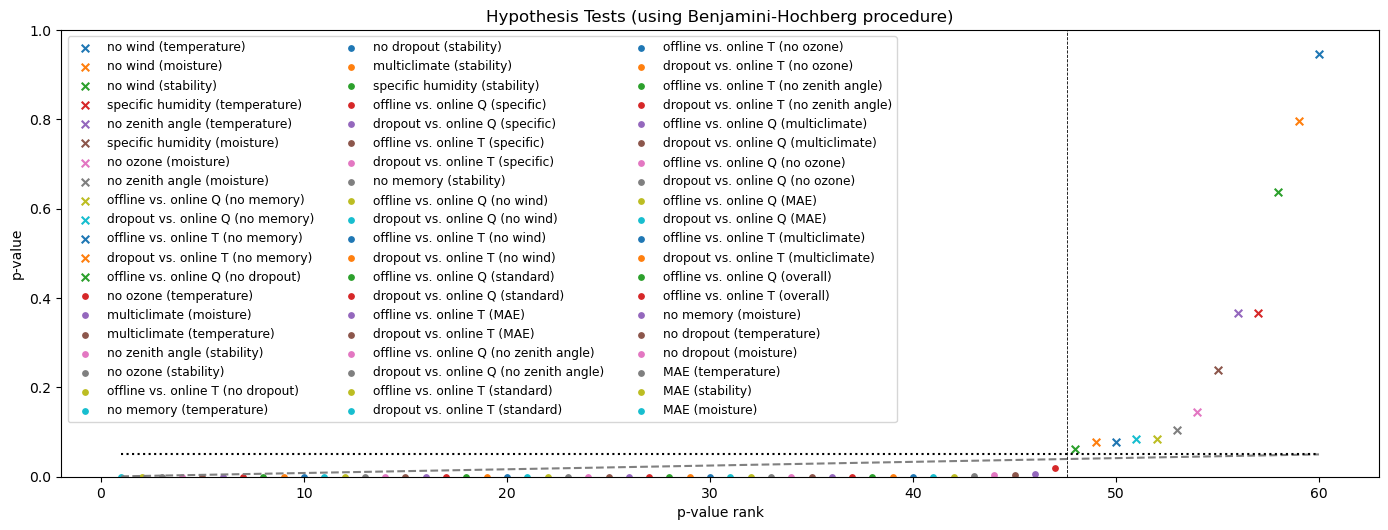

In [14]:
plt.figure(figsize=(17, 5.8))
x_range = range(1, num_tests + 1)
plt.plot(x_range, alpha_scaled, color = 'grey', linestyle = '--')
plt.plot(x_range, [alpha_global for x in range(num_tests)], color = 'black', linestyle = ':')
plt.ylim(0, 1)
plt.xlabel('p-value rank')
plt.ylabel('p-value')
crossed = False
handles = []
for rank, pval, test in reversed(list(zip(x_range, sorted_pvals, sorted_tests))):
    if pval >= alpha_scaled[rank - 1] and not crossed:
        handle = plt.scatter(rank, pval, s = 30, marker = 'x', label = test)
        handles.append(handle)
    elif pval < alpha_scaled[rank - 1]:
        crossed = True
        handle = plt.scatter(rank, pval, s = 60, marker = '.', label = test)
        handles.append(handle)
plt.axvline(x = 47.6, linestyle = '--', linewidth = .6, color = 'black')
plt.legend(loc = 'upper left', handles = handles, ncol = 3, fontsize = 8.8)
plt.title('Hypothesis Tests (using Benjamini-Hochberg procedure)')

# Sample size estimation

In [10]:
# def getpower(baseline_arr, loc_shift, sample_size, num_iter = 10000):
#     num_reject = 0
#     for i in range(num_iter):
#         bootstrap = baseline_arr.sample(sample_size*2, replace = True)
#         bootstrap[sample_size:] = bootstrap[sample_size:] + loc_shift
#         stat, p_value = ranksums(bootstrap[:sample_size], bootstrap[sample_size:])
#         if p_value < 0.05:
#             num_reject += 1
#     return num_reject/num_iter

# mann whitney approach
loc_shift = np.median(survived_dict['noozone']['online_temperature']) - np.median(survived_dict['standard']['online_temperature'])
ustat, u_pval = mannwhitneyu(survived_dict['standard']['online_temperature'], survived_dict['standard']['online_temperature'] + loc_shift)
math.ceil(math.ceil(((norm.ppf(.8) + norm.ppf(.95))**2)/(6*(((ustat/(141*141))-.5)**2)))*(330/141))

384

# Parameter count scatterplots

Text(0.5, 1.0, 'Parameter Count vs. Online Temperature RMSE')

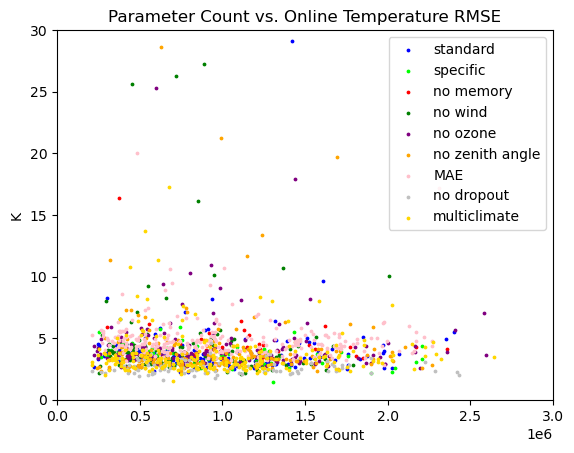

In [11]:
plt.scatter(survived_dict['standard']['parameter_count'], survived_dict['standard']['online_temperature'], color = color_dict['standard'], label = 'standard', s = 3)
plt.scatter(survived_dict['specific']['parameter_count'], survived_dict['specific']['online_temperature'], color = color_dict['specific'], label = 'specific', s = 3)
plt.scatter(survived_dict['nomemory']['parameter_count'], survived_dict['nomemory']['online_temperature'], color = color_dict['nomemory'], label = 'no memory', s = 3)
plt.scatter(survived_dict['nowind']['parameter_count'], survived_dict['nowind']['online_temperature'], color = color_dict['nowind'], label = 'no wind', s = 3)
plt.scatter(survived_dict['noozone']['parameter_count'], survived_dict['noozone']['online_temperature'], color = color_dict['noozone'], label = 'no ozone', s = 3)
plt.scatter(survived_dict['nocoszrs']['parameter_count'], survived_dict['nocoszrs']['online_temperature'], color = color_dict['nocoszrs'], label = 'no zenith angle', s = 3)
plt.scatter(survived_dict['mae']['parameter_count'], survived_dict['mae']['online_temperature'], color = color_dict['mae'], label = 'MAE', s = 3)
plt.scatter(survived_dict['nodropout']['parameter_count'], survived_dict['nodropout']['online_temperature'], color = color_dict['nodropout'], label = 'no dropout', s = 3)
plt.scatter(survived_dict['multiclimate']['parameter_count'], survived_dict['multiclimate']['online_temperature'], color = color_dict['multiclimate'], label = 'multiclimate', s = 3)

plt.ylabel('K')
plt.xlabel('Parameter Count')
plt.xlim(0, 3e6)
plt.ylim(0, 30)
plt.legend()
plt.title('Parameter Count vs. Online Temperature RMSE')

Text(0.5, 1.0, 'Parameter Count vs. Online Moisture RMSE')

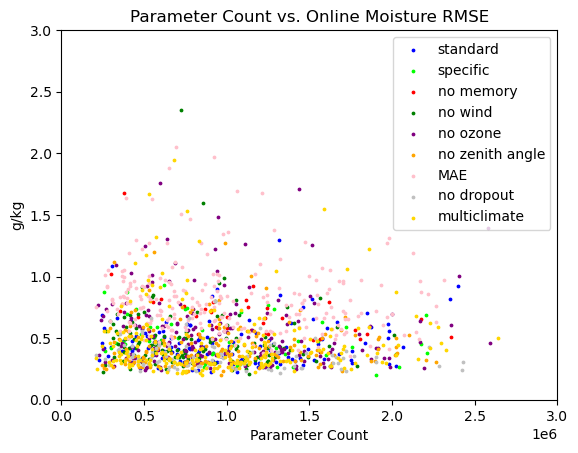

In [12]:
plt.scatter(survived_dict['standard']['parameter_count'], survived_dict['standard']['online_moisture'], color = color_dict['standard'], label = 'standard', s = 3)
plt.scatter(survived_dict['specific']['parameter_count'], survived_dict['specific']['online_moisture'], color = color_dict['specific'], label = 'specific', s = 3)
plt.scatter(survived_dict['nomemory']['parameter_count'], survived_dict['nomemory']['online_moisture'], color = color_dict['nomemory'], label = 'no memory', s = 3)
plt.scatter(survived_dict['nowind']['parameter_count'], survived_dict['nowind']['online_moisture'], color = color_dict['nowind'], label = 'no wind', s = 3)
plt.scatter(survived_dict['noozone']['parameter_count'], survived_dict['noozone']['online_moisture'], color = color_dict['noozone'], label = 'no ozone', s = 3)
plt.scatter(survived_dict['nocoszrs']['parameter_count'], survived_dict['nocoszrs']['online_moisture'], color = color_dict['nocoszrs'], label = 'no zenith angle', s = 3)
plt.scatter(survived_dict['mae']['parameter_count'], survived_dict['mae']['online_moisture'], color = color_dict['mae'], label = 'MAE', s = 3)
plt.scatter(survived_dict['nodropout']['parameter_count'], survived_dict['nodropout']['online_moisture'], color = color_dict['nodropout'], label = 'no dropout', s = 3)
plt.scatter(survived_dict['multiclimate']['parameter_count'], survived_dict['multiclimate']['online_moisture'], color = color_dict['multiclimate'], label = 'multiclimate', s = 3)

plt.ylabel('g/kg')
plt.xlabel('Parameter Count')
plt.xlim(0, 3e6)
plt.ylim(0, 3)
plt.legend()
plt.title('Parameter Count vs. Online Moisture RMSE')

# Zonal mean eval

In [13]:
sp_path = '/ocean/projects/atm200007p/jlin96/longSPrun_clean/trim_dir/trimmed/'
sp_list = os.popen(" ".join(["ls", sp_path + "*.h1.0000*"])).read().splitlines()
sp_data = xr.open_mfdataset(sp_list)
sp_temp = sp_data['NNTBSP'].mean(dim = ['time', 'lon'])
sp_hum = sp_data['NNQBSP'].mean(dim = ['time', 'lon'])*1000
X, Y = np.meshgrid(np.sin(sp_data["lat"]*np.pi/180), np.array(range(30)))
pressure_grid = sp_data['P0']*sp_data['hyam'] + sp_data['hybm']*sp_data['NNPSBSP']
Y = pressure_grid.mean(dim = ['lon', 'time']).values

def plot_zonal_diff(config, model_rank, var = 'NNTBSP'):
    model_rank = str(model_rank).zfill(3)
    nn_path = '/ocean/projects/atm200007p/jlin96/nnspreadtesting_good/{}/coupled_results/{}_model_{}/'.format(config, config, model_rank)
    nn_list = os.popen(" ".join(["ls", nn_path + "*.h1.0000*"])).read().splitlines()
    nn_data = xr.open_mfdataset(nn_list)
    if var == 'NNTBSP':
        nn_var = nn_data['NNTBSP'].mean(dim = ['time', 'lon'])
        sp_var = sp_temp
        vmin = -5
        vmax = 5
        var_title = 'Zonal mean temperature difference in (K)'
        cmap = 'bwr'
    elif var == 'NNQBSP':
        nn_var = nn_data['NNQBSP'].mean(dim = ['time', 'lon'])*1000
        sp_var = sp_hum
        vmin = -5
        vmax = 5
        var_title = 'Zonal mean humidity difference in (g/kg)'
        cmap = 'BrBG'
    plt.pcolormesh(X, Y, nn_var - sp_var, cmap = cmap, vmin = vmin, vmax = vmax)
    plt.xticks([np.sin(-50/180*np.pi), 0, np.sin(50/180*np.pi)], ['50$^\circ$S', '0$^\circ$', '50$^\circ$N'])
    plt.xlabel('latitude')
    plt.ylabel('pressure')
    plt.title(var_title)
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.show()

def showplots(config, model_info, var = "NNTBSP"):
    if var == 'NNTBSP':
        ranks = model_info[model_info['num_months']==12]['online_temperature'].sort_values().head().index
    elif var == 'NNQBSP':
        ranks = model_info[model_info['num_months']==12]['online_moisture'].sort_values().head().index
    for rank in ranks:
        plot_zonal_diff(config, rank, var)

ls: /ocean/projects/atm200007p/jlin96/longSPrun_clean/trim_dir/trimmed/*.h1.0000*: No such file or directory


OSError: no files to open